In [1]:
import warnings
warnings.filterwarnings("ignore") 


import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(1966)

from sklearn.preprocessing import LabelEncoder
import statsmodels.api as statsmodels
from copy import deepcopy

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/Users/burdziac/Documents/PDAC/notebooks_final_June2021/downstream_analysis/cleaned/FinalVersions'

In [4]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Functions

In [5]:
def kneepoint(vec):
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.tile(lineVecNorm, (nPoints, 1)), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

# Hard-coded Metadata

In [6]:
color_dict= {"T1 (Basal)":"#DAF7A6",
"T2":"#A1BE6C",
"T3":"#EED04D",
"T3.5":"#D4AA47",
"T4-day1":"#1D89E3",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T6":"#D16BA7",
"T7_PDAC":"#BD14DA",
"T8_LiverMet":"#63009B",
"T8_PDAC_LiverMets":"#63009B",
"T8_PDAC_LungMets":"#63009B"}

In [7]:
stage_dict = {'184RH_PDAC-PT_KATE_GFP': 'T7_PDAC',
 '184RRH_LIVmet': 'T8_PDAC_LiverMets',
 'Ag-PDAC-PT-Kate': 'T7_PDAC',
 'D396_EPI': 'T3.5',
 'DAC_B528-Kate+': 'T4',
 'DAC_B530-Kate+': 'T2',
 'DAC_C263_EPI': 'T3.5',
 'DAC_C269_EPI': 'T5',
 'DAC_C301-EPI_1': 'T6',
 'DAC_C301-EPI_2': 'T6',
 'DAC_D020_p5_Epi': 'T7_PDAC',
 'DAC_DI143_Epi': 'T5',
 'DACC963_mKate_plus': 'T8_PDAC_LungMets',
 'DACC963LIVERmet': 'T8_LiverMet',
 'DACC963PT_Kate_plus': 'T7_PDAC',
 'DACD351_Kate_plus': 'T3',
 'DACD394_Kate_plus': 'T3',
 'DACD403_Kate_plus': 'T2',
 'DACD404_Kate_plus': 'T4',
 'DACD406_Kate_plus': 'T3',
 'DACD407_Kate_plus': 'T4-day1',
 'DACD482_Kate_plus': 'T5',
 'Ag-Lung-Mets-Kate': 'T8_PDAC_LungMets',
 'DACD511_Kate_plus': 'T1 (Basal)',
 'DACD550_kate_plus': 'T1 (Basal)'}

stage_dict2 = {
'DACD408-CD45+':"T3",
 'DACD143-CD45+': 'T5',
 'DACD351-CD45+': 'T3',
 'DACD394-CD45+': 'T3',
 'DACD403-CD45+': 'T2',
 'DACD404-CD45+': 'T4',
 'DACD406-CD45+': 'T3',
 'DACD407-CD45+': 'T4-day1',
 'DACD482-CD45+': 'T5'}

stage_dict.update(stage_dict2)

In [8]:
order = ['DACD406_Kate_plus',
'DACD351_Kate_plus',
"DACD404_Kate_plus",
"DACD407_Kate_plus",
"DAC_DI143_Epi",
"DACD482_Kate_plus"]

# Data Integration

## Load Data Original Data

In [9]:
sc_epi = load_sc(working_dir+"saved_analyses/ImmuneCrosstalkSet_v1.pickle")

In [10]:
sc_immune = load_sc(working_dir+"saved_analyses/CD45Plus_CrosstalkSubset.pickle")

## Combine Epithelial and Immune Count Matrices

In [11]:
genes_needed_sc = set(list(sc_immune.data))-set(list(sc_epi.data))
sc_data_full = pd.concat([sc_epi.data, pd.DataFrame(columns = genes_needed_sc)],sort=False).fillna(0)

genes_needed_immune = set(list(sc_epi.data))-set(list(sc_immune.data))
sc_immune_data_full = pd.concat([sc_immune.data, pd.DataFrame(columns = genes_needed_immune)],sort=False).fillna(0)

In [12]:
sc_data_full = sc_data_full[list(sc_immune_data_full)] #line up genes

In [13]:
sc_data_full[genes_needed_sc].values.sum()

0

In [14]:
sc_data_full[genes_needed_immune].values.sum()

3255998.0

In [15]:
sc_immune_data_full[genes_needed_immune].values.sum()

0

In [16]:
sc_immune_data_full[genes_needed_sc].values.sum()

425328.0

In [17]:
np.array_equal(np.array(list(sc_immune_data_full)),np.array(list(sc_data_full)))

True

In [18]:
sc_data_full.index = ["{}_Epi".format(cell) for cell in sc_data_full.index]
sc_immune_data_full.index = ["{}_Immune".format(cell) for cell in sc_immune_data_full.index]

In [19]:
sc_data_full

,WTIP,HIST1H2AN,AAMP,SDSL,SNX32,WDR95,PITPNM1,UBAP2,LYVE1,DCK,...,ADAMTS20,LNCENC1,CEND1,SAMD12,GM14133,SHANK2,GM42504,TEX38,GM12860,ZFP853
120726897159011_Epi,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
120726943128374_Epi,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772934154972_Epi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772948540139_Epi,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772961618869_Epi,1.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241106375334635_Epi,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
241106389461299_Epi,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241106402274205_Epi,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241106420690348_Epi,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
sc_immune_data_full

,WTIP,HIST1H2AN,AAMP,SDSL,SNX32,WDR95,PITPNM1,UBAP2,LYVE1,DCK,...,ADAMTS20,LNCENC1,CEND1,SAMD12,GM14133,SHANK2,GM42504,TEX38,GM12860,ZFP853
120703436155294_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
120703436634421_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
120703455259550_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
120726896889262_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
120726924193123_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241106401848180_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
241114589285093_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
241114589810078_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
241114608416565_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data_full = pd.concat((sc_data_full,sc_immune_data_full))

In [22]:
data_full

,WTIP,HIST1H2AN,AAMP,SDSL,SNX32,WDR95,PITPNM1,UBAP2,LYVE1,DCK,...,ADAMTS20,LNCENC1,CEND1,SAMD12,GM14133,SHANK2,GM42504,TEX38,GM12860,ZFP853
120726897159011_Epi,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
120726943128374_Epi,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772934154972_Epi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772948540139_Epi,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120772961618869_Epi,1.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241106401848180_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241114589285093_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241114589810078_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241114608416565_Immune,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
sc_epi.data.shape

(8525, 16826)

In [24]:
sc_immune.data.shape

(11283, 13408)

In [25]:
sc_immune.data.shape[0] + sc_epi.data.shape[0]

19808

In [26]:
np.union1d(list(sc_immune.data),list(sc_epi.data)).shape #total number of genes

(17351,)

In [27]:
data_full.shape

(19808, 17351)

## Create sc Object

In [28]:
#populate required data for sc class
sc = scutils_cnb_clean.sc()

sc.genes = np.array(list(data_full))
sc.data = deepcopy(data_full)
sc.sample_ids = np.concatenate((sc_epi.sample_ids,sc_immune.sample_ids))
sc.cell_ids = np.concatenate((sc_epi.cell_ids,sc_immune.cell_ids))
sc.lib_size = np.concatenate((sc_epi.lib_size,sc_immune.lib_size))
sc.gene_expression = np.concatenate((sc_epi.gene_expression,sc_immune.gene_expression))
sc.gene_detection = np.concatenate((sc_epi.gene_detection,sc_immune.gene_detection))

In [29]:
sc.data_normalized = pd.DataFrame(sc.data.values / sc.lib_size[:,None] * 10000,
                                  columns = sc.genes, index=sc.cell_ids)

In [30]:
#remove 0 sum genes
sc.data_normalized = sc.data_normalized.iloc[:,np.where(sc.data_normalized.sum(0).values!=0)[0]]
sc.genes = sc.data_normalized.columns

In [31]:
#impute
magic_operator = magic.MAGIC(t=2,n_pca=50)
sc.data_imputed = magic_operator.fit_transform(np.log2(data_full+.1))

Calculating MAGIC...
  Running MAGIC on 19808 cells and 17351 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 13.69 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.78 seconds.
    Calculating affinities...
    Calculated affinities in 6.94 seconds.
  Calculated graph and diffusion operator in 28.89 seconds.
  Running MAGIC with `solver='exact'` on 17351-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 22.35 seconds.
Calculated MAGIC in 60.49 seconds.


# HVG Selection

In [32]:
mean = sc.data_normalized.mean(0)
std = sc.data_normalized.std(0)
output = statsmodels.nonparametric.lowess(np.log(std**2/mean+.1).values,
                                                           np.log(mean+.1).values,
                                                          return_sorted=False)
residuals = output - np.log(std**2/mean+.1)

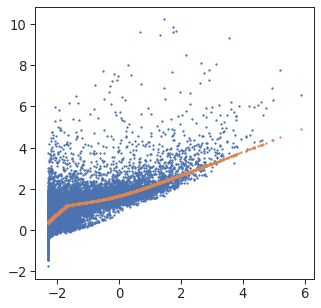

In [33]:
fig,ax=plt.subplots(figsize=(5,5))
plt.scatter(np.log(mean+.1),np.log(std**2/mean+.1),s=2)
plt.scatter(np.log(mean+.1),output,s=2)

In [34]:
nwindows = 41
step = int(np.ceil(len(mean)/nwindows))
keep = []
for i in range(nwindows-1):
    start = (i+1)*step
    stop = (i+2)*step
    genes_ = np.argsort(mean.values)[start:stop]
    genes_resids = residuals[genes_]
    keep.append(genes_[np.argsort(genes_resids)[:200]])
keep = np.hstack(keep)

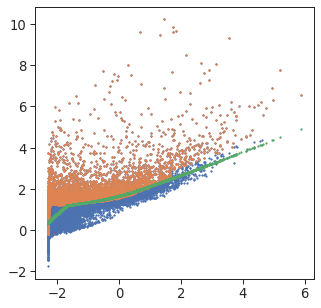

In [35]:
fig,ax=plt.subplots(figsize=(5,5))
plt.scatter(np.log(mean+.1),np.log(std**2/mean+.1),s=2)
plt.scatter(np.log(mean+.1)[keep],np.log(std**2/mean+.1)[keep],s=2)
plt.scatter(np.log(mean+.1),output,s=2)

In [36]:
len(set(keep))

8000

In [37]:
#save other genes in case we need their expression later
data_full = deepcopy(sc.data_normalized)
sc.filter_genes_indices(keep)

# Embedding Post-Filtering

PCA on Log-Transformed, Normalized Counts:
# PCs: 9
% Variance Explained: 0.30796951598737454
 
PCA on Normalized (un-transformed) Counts:
# PCs: 22
% Variance Explained: 0.9283472702373227


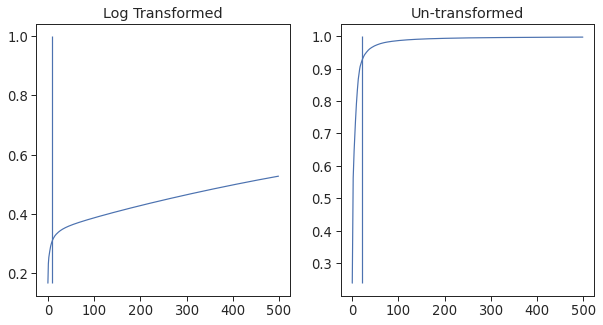

In [38]:
sc.pca(npca=500)

In [39]:
cms = np.cumsum(sc.pc_log_explained_var)
knee = kneepoint(cms)
print(knee)
print("Variance explained: ",cms[knee])

40
Variance explained:  0.3556796844569717


Text(0.5, 1.0, 'Log Transformed')

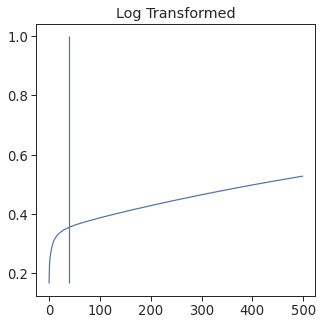

In [40]:
#manually adjust
fig,axes = plt.subplots(figsize=(5,5))

axes.plot(np.cumsum(sc.pc_log_explained_var))
axes.vlines(knee,ymin=sc.pc_log_explained_var[0],ymax=1)
axes.set_title("Log Transformed")

In [41]:
sc.npca_log = knee

In [42]:
sc.tSNE(perplexity=150)

Performing tSNE on PCs...


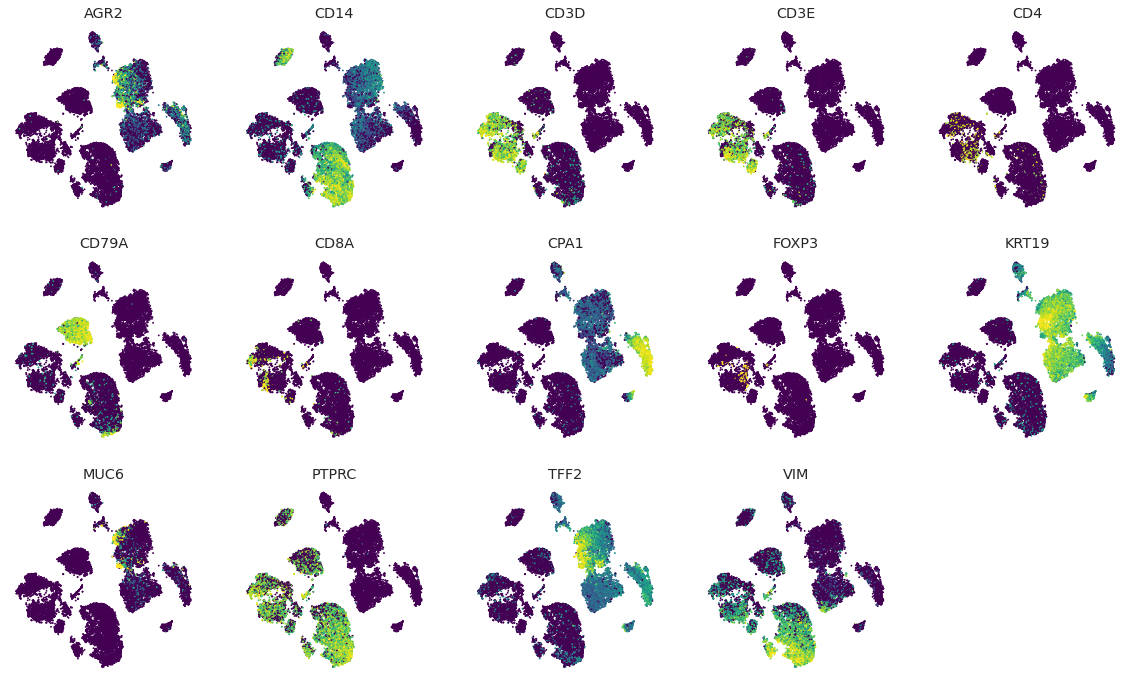

In [43]:
gene_plot(sc.tsne_log,sc.data_normalized,['PTPRC','CD79A','CD3E','CD3D','CD8A','CD4','CD14',
                                         'CPA1','KRT19','VIM','GNLY','MUC6','AGR2','TFF2','FOXP3'],s=1,cmap='viridis')

In [44]:
le = LabelEncoder()
le.fit(sc_immune.communities_refined)

LabelEncoder()

In [45]:
sc.communities_coarse = np.concatenate((sc_epi.communities_coarse,
                           le.transform(sc_immune.communities_refined)+np.max(sc_epi.communities_coarse)+1))

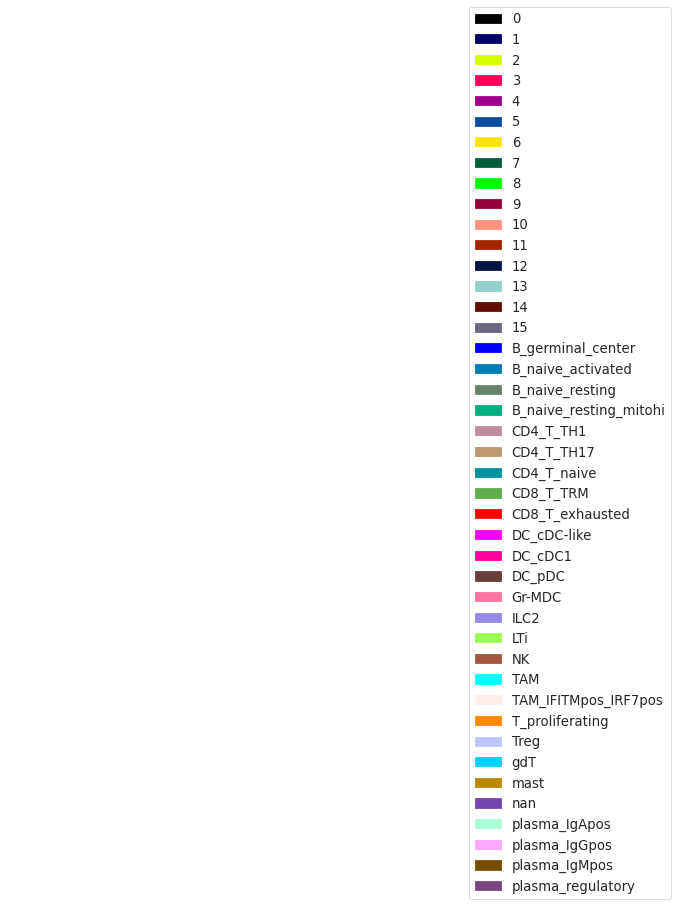

In [46]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()


patches = []
for color in range(np.max(sc_epi.communities_coarse)+1):
    patches.append(mpatches.Patch(color=sc.palette[color],label=color))
    
for color2 in range(np.max(le.transform(sc_immune.communities_refined))+1):
    patches.append(mpatches.Patch(color=sc.palette[color2+np.max(sc_epi.communities_coarse)+1],
                                  label=le.classes_[color2]))
ax.legend(handles=patches,loc=0,borderaxespad=-8)

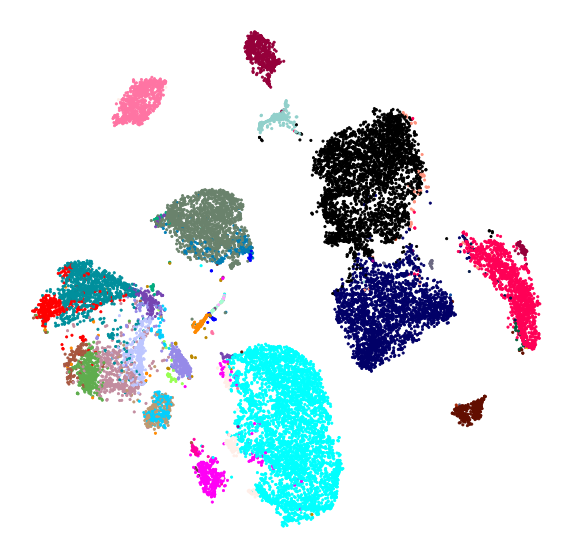

In [47]:
fig,ax = plt.subplots(figsize=(10,10))
order_ = np.random.choice(sc.sample_ids.shape[0],size=sc.sample_ids.shape[0],replace=False)
colors = np.array([sc.palette[i] for i in sc.communities_coarse])
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
         c=colors[order_],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_ClusterAnnot.png",bbox_inches='tight')

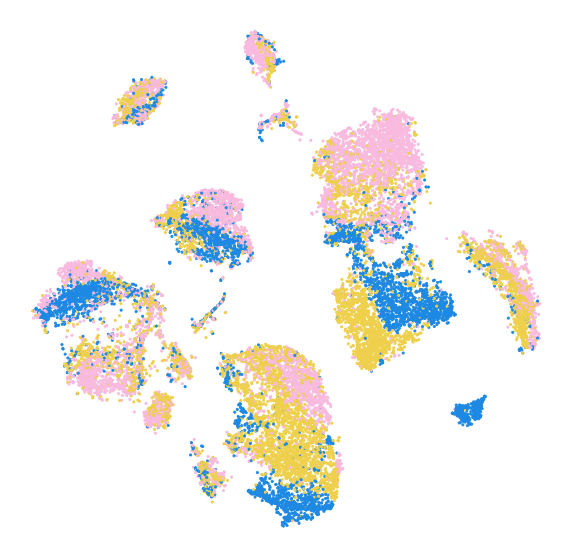

In [48]:
fig,ax = plt.subplots(figsize=(10,10))
order_ = np.random.choice(sc.sample_ids.shape[0],size=sc.sample_ids.shape[0],replace=False)
colors = np.array([color_dict[stage_dict[i]] for i in sc.sample_ids])
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
         c=colors[order_],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_SampleAnnot.png",bbox_inches='tight')

# Feedback Loop Visualization

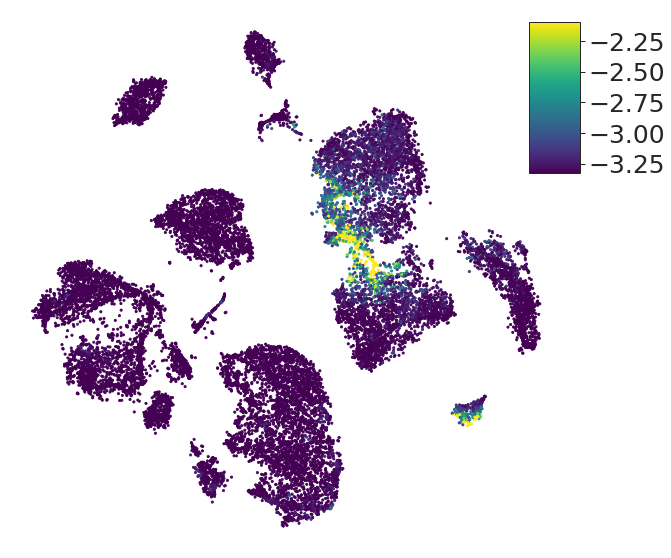

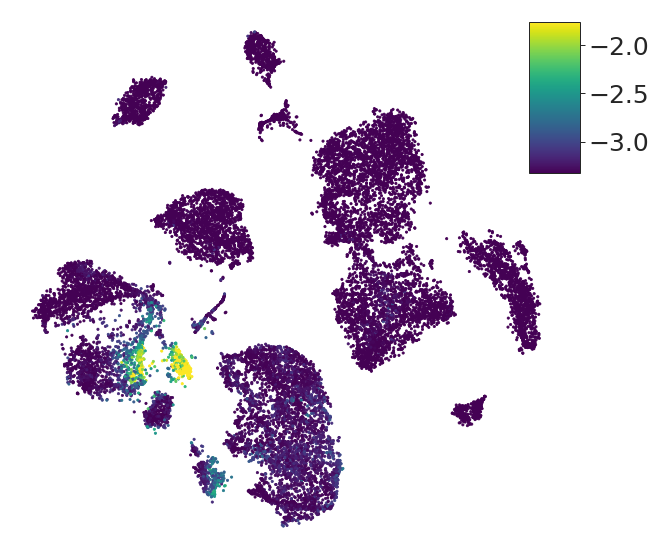

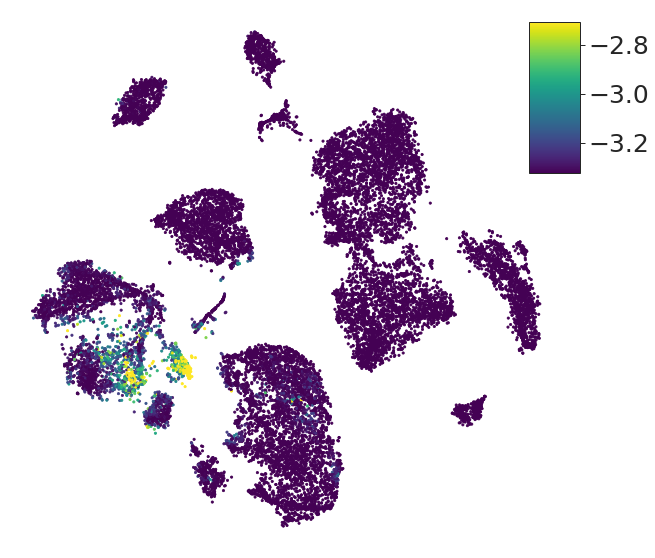

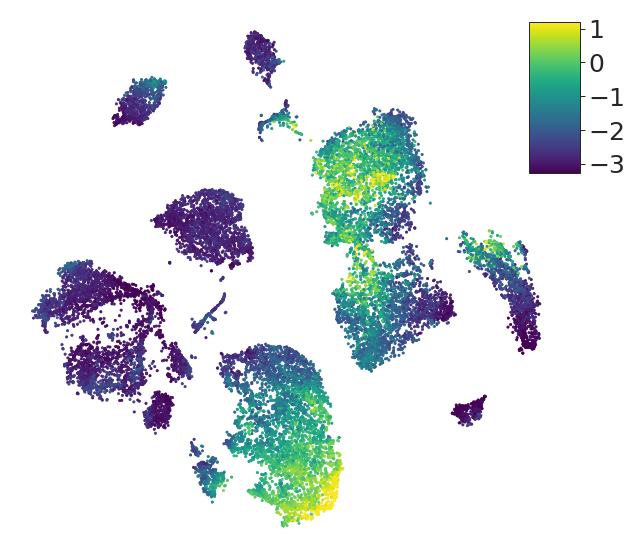

In [49]:
for geneset in ['IL33','IL1RL1','IL4','IL4RA']:
    color=sc.data_imputed[geneset].values
    fig,ax=plt.subplots(figsize=(10,10))
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)

    
    scatterplt = ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
                  c=color[order_],
                  vmin=np.percentile(color,1),
                  vmax=np.percentile(color,99),
                  cmap='viridis',s=5)
    
        #add colorbar
    cax = fig.add_axes([.85, .65, 0.07, 0.21])
    cbar = fig.colorbar(scatterplt, cax)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(25)
        
    ax.set_axis_off()
    plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_{}.png".format(geneset),bbox_inches='tight')

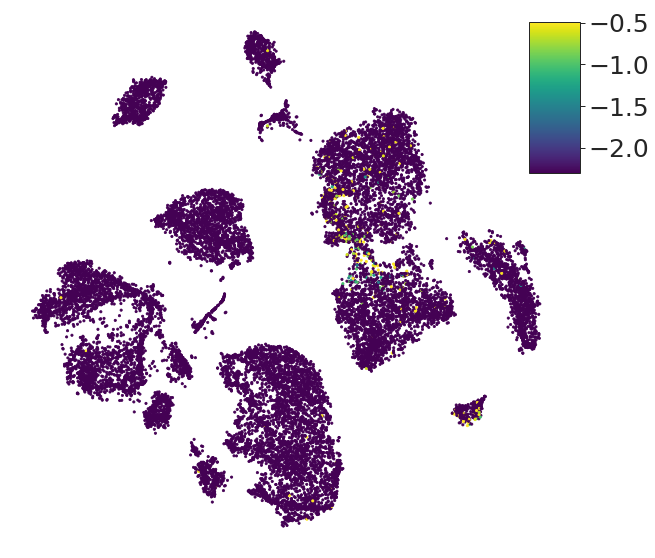

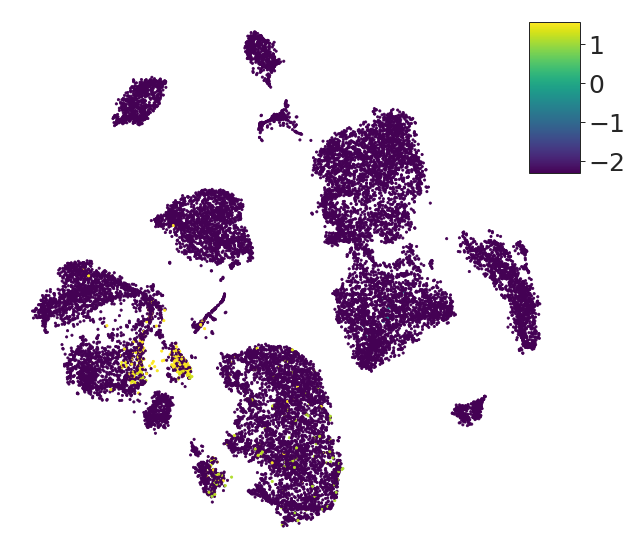

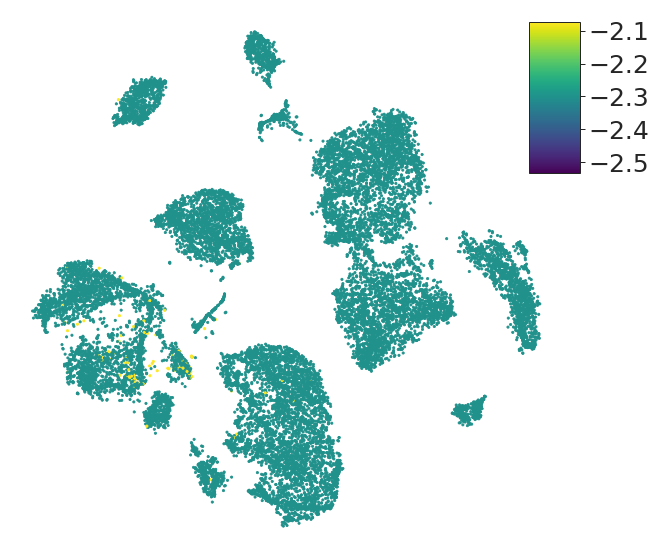

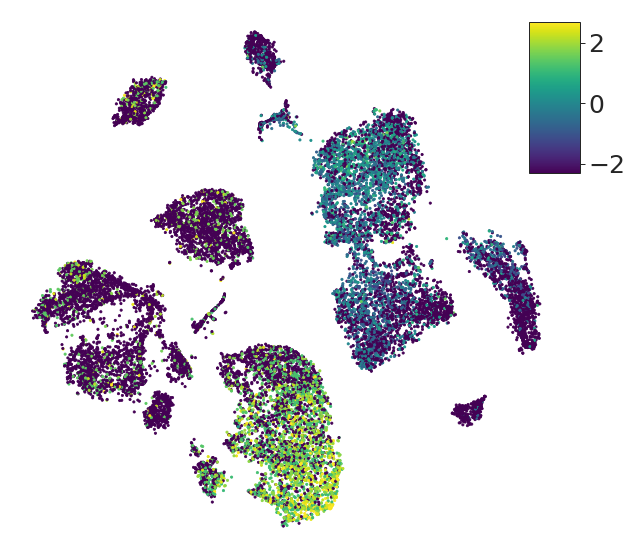

In [50]:
sc.data_full = data_full.copy()

for geneset in ['IL33','IL1RL1','IL4','IL4RA']:
    color=np.log(sc.data_full[geneset].values+.1)
    fig,ax=plt.subplots(figsize=(10,10))
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)

    
    scatterplt = ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
                  c=color[order_],
                  vmin=np.percentile(color,1),
                  vmax=np.percentile(color,99),
                  cmap='viridis',s=5)
    
            #add colorbar
    cax = fig.add_axes([.85, .65, 0.07, 0.21])
    cbar = fig.colorbar(scatterplt, cax)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(25)
        
        
    ax.set_axis_off()
    plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_{}_unimpute.png".format(geneset),bbox_inches='tight')

# Module Visualization

In [51]:
cliques_epi = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_Epi.pickle",'rb'))
cliques_tnkilc = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_TNKILC.pickle",'rb'))
cliques_b = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_B.pickle",'rb'))
cliques_myeloid = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_myeloid.pickle",'rb'))

In [52]:
rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[1,1,1],                         
[0,0,1],
[1,0,1],
[0,.6,0],])

In [53]:
def mod_assignment(data,cliques):
    mat3 = []
    for i,cl in enumerate(cliques):
        cl_ = np.intersect1d(cl,list(sc.data_normalized))
        mat3.append(data[cl_].mean(1))
    mat3 = np.vstack(mat3)

    mat3 = ((mat3.T-mat3.mean(1))/mat3.std(1)).T

    mod_assignment_ = np.argmax(mat3,axis=0)
    
    return mod_assignment_

In [54]:
data_logged = np.log2(sc.data_normalized+.1)
data_logged_zscored = (data_logged-data_logged.mean(0).values)/data_logged.std(0).values

In [55]:
mod_assignment_epi = mod_assignment(data_logged_zscored,cliques_epi)
mod_assignment_tnkilc = mod_assignment(data_logged_zscored,cliques_tnkilc)
mod_assignment_b = mod_assignment(data_logged_zscored,cliques_b)
mod_assignment_myeloid = mod_assignment(data_logged_zscored,cliques_myeloid)

In [56]:
#to match naming convention
mod_assignment_epi_adjust = mod_assignment_epi + 1
mod_assignment_tnkilc_adjust = mod_assignment_tnkilc + 8
mod_assignment_b_adjust = mod_assignment_b + 22
mod_assignment_myeloid_adjust = mod_assignment_myeloid + 15

In [57]:
sample_type = np.array([val.split("_")[-1] for val in sc.data.index])
epi_cells = np.where(sample_type=="Epi")[0]
immune_cells = np.where(sample_type!="Epi")[0]
assignments_epi = mod_assignment_epi[epi_cells]

In [58]:
tnkilc_cells = immune_cells[np.where(np.array([cluster in ['CD4_T','CD8_T','ILC','T','gdT'] for cluster in sc_immune.communities_coarse]))[0]]
b_cells  = immune_cells[np.where(np.array([cluster in ['B','plasma'] for cluster in sc_immune.communities_coarse]))[0]]
myeloid_cells  = immune_cells[np.where(np.array([cluster in ['DC','Gr-MDC','TAM','mast'] for cluster in sc_immune.communities_coarse]))[0]]

In [59]:
full_mods = np.zeros(sc.data.shape[0]).astype(np.int32)
full_mods[epi_cells] = mod_assignment_epi_adjust[epi_cells]
full_mods[tnkilc_cells] = mod_assignment_tnkilc_adjust[tnkilc_cells]
full_mods[b_cells] = mod_assignment_b[b_cells]
full_mods[myeloid_cells] = mod_assignment_myeloid[myeloid_cells]

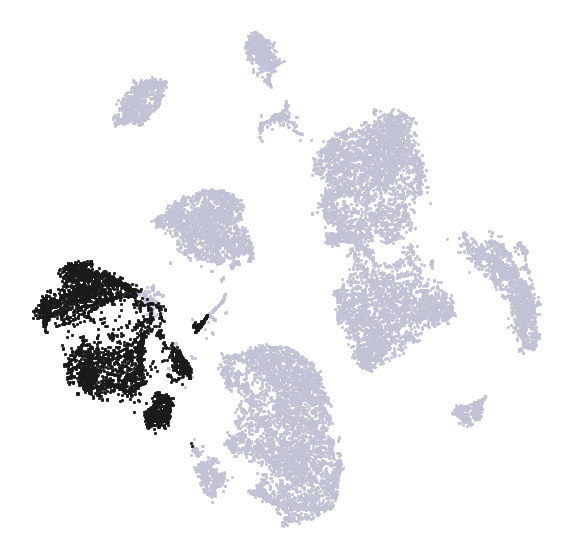

In [60]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][tnkilc_cells],sc.tsne_log[:,1][tnkilc_cells],
         c='k',s=5)
ax.set_axis_off()

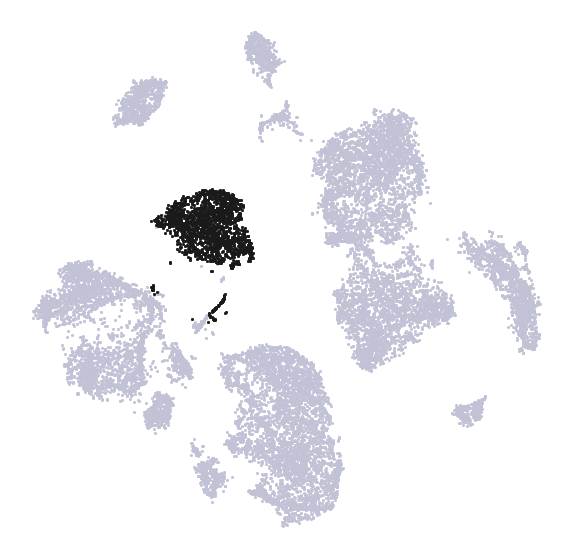

In [61]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][b_cells],sc.tsne_log[:,1][b_cells],
         c='k',s=5)
ax.set_axis_off()

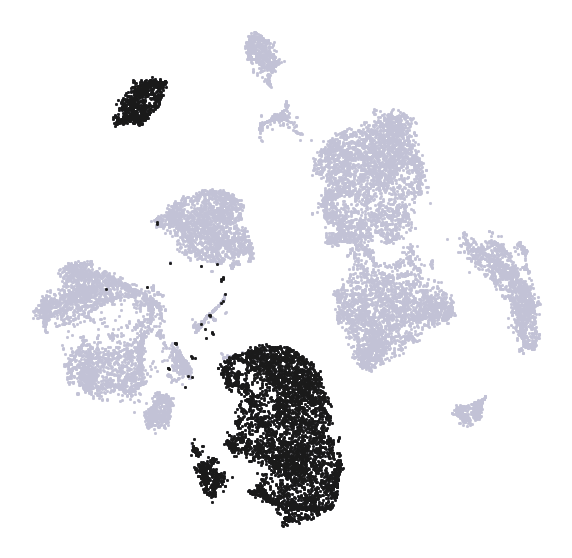

In [62]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][myeloid_cells],sc.tsne_log[:,1][myeloid_cells],
         c='k',s=5)
ax.set_axis_off()

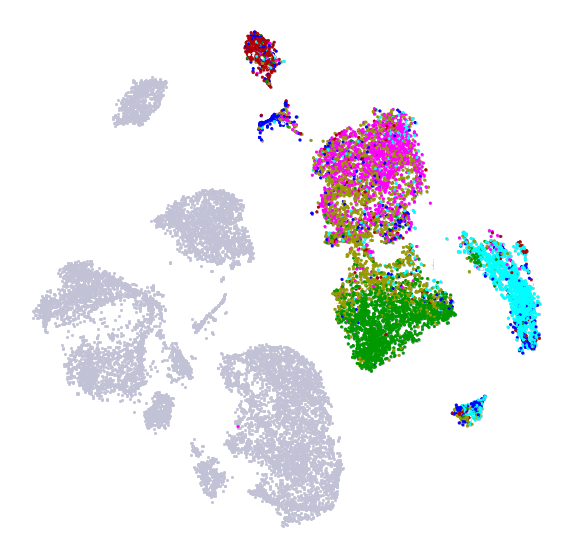

In [63]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][epi_cells],sc.tsne_log[:,1][epi_cells],
         c=rgb_cols_all[assignments_epi[epi_cells]],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_Modules.png",bbox_inches='tight')

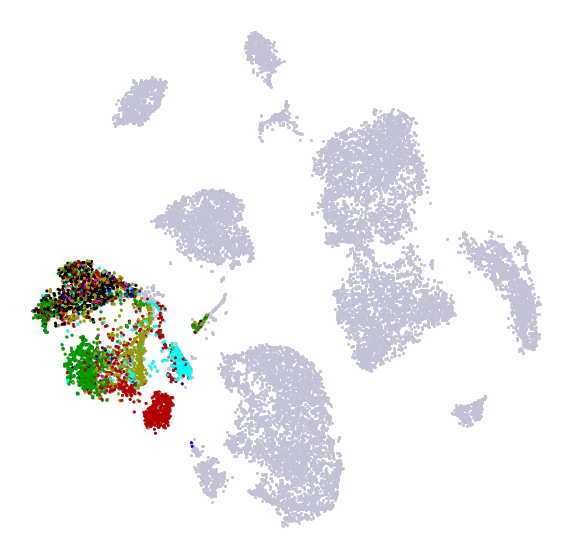

In [64]:
fig,ax = plt.subplots(figsize=(10,10))
rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,0],                         
[0,0,1],
[1,0,1],
[0,.6,0],]) #one row longer than epi

ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][tnkilc_cells],sc.tsne_log[:,1][tnkilc_cells],
         c=rgb_cols_all[mod_assignment_tnkilc[tnkilc_cells]],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_Modules_TNKILC.png",bbox_inches='tight')

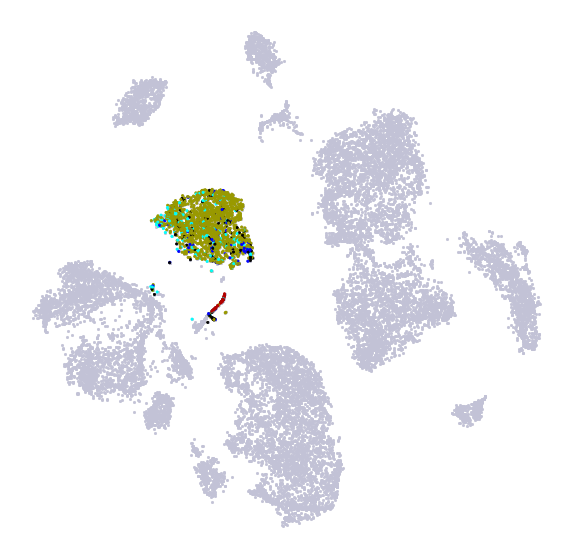

In [65]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][b_cells],sc.tsne_log[:,1][b_cells],
         c=rgb_cols_all[mod_assignment_b[b_cells]],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_Modules_B.png",bbox_inches='tight')

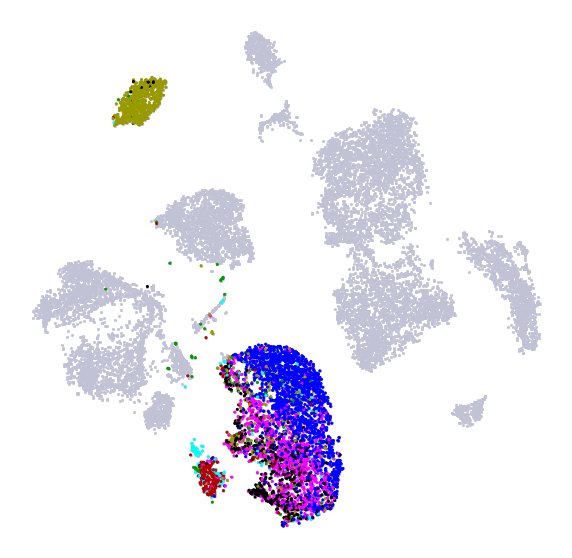

In [66]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sc.tsne_log[:,0],sc.tsne_log[:,1],
         c="#C2C2D6",s=5)

ax.scatter(sc.tsne_log[:,0][myeloid_cells],sc.tsne_log[:,1][myeloid_cells],
         c=rgb_cols_all[mod_assignment_myeloid[myeloid_cells]],s=5)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_Modules_myeloid.png",bbox_inches='tight')

# IL33 Pathway Step Visualization

In [67]:
layers = pickle.load(open(working_dir+"analysis_outputs/IL33_modulelayers.pickle",'rb'))

In [68]:
for key in layers.keys():
    try:
        layers[key] = np.min(layers[key])#np.max(layers[key])
    except:
        layers[key] = -1

In [69]:
layers

{1: 3,
 2: -1,
 3: 3,
 4: 2,
 5: -1,
 6: 1,
 7: 2,
 8: 0,
 9: 3,
 10: 4,
 11: 1,
 12: 2,
 13: -1,
 14: 3,
 15: -1,
 16: -1,
 17: 2,
 18: 2,
 19: 3,
 20: 1,
 21: -1,
 22: -1,
 23: 2,
 24: -1,
 25: 4,
 26: 4}

In [70]:
layers[0] = -1

In [90]:
np.max(layers)

{1: 3,
 2: -1,
 3: 3,
 4: 2,
 5: -1,
 6: 1,
 7: 2,
 8: 0,
 9: 3,
 10: 4,
 11: 1,
 12: 2,
 13: -1,
 14: 3,
 15: -1,
 16: -1,
 17: 2,
 18: 2,
 19: 3,
 20: 1,
 21: -1,
 22: -1,
 23: 2,
 24: -1,
 25: 4,
 26: 4,
 0: -1}

In [93]:
palette = {i:np.array([1.0,i/10,i/10]) for i in np.arange(0,10)}
palette[-1] = "lavender"

colors = [palette[layers[mod]] for mod in full_mods]

palette = {1:"#2D58BD",
          0:"#3D388F",2:"#00A5E1",
          3:"#53D5D7",4:'#7BEDD3',
          5:"#C4F2CE",6:"#E4EEE6",7:'#ECEEEC',8:'#FFFFFF',-1:'lavender'}

palette = {
          0:"#3D388F",
          1:"#53D5D7",
          2:"#C4F2CE",3:"#E4EEE6",4:'#ECEEEC',-1:'lavender'}


colors = [palette[layers[mod]] for mod in full_mods]

In [100]:
cmap = matplotlib.cm.get_cmap('hot')

palette = {int(i*6):cmap(i) for i in np.arange(0,6,.1)}
palette[-1] = "#FFFFFF"

colors = [palette[layers[mod]] for mod in full_mods]

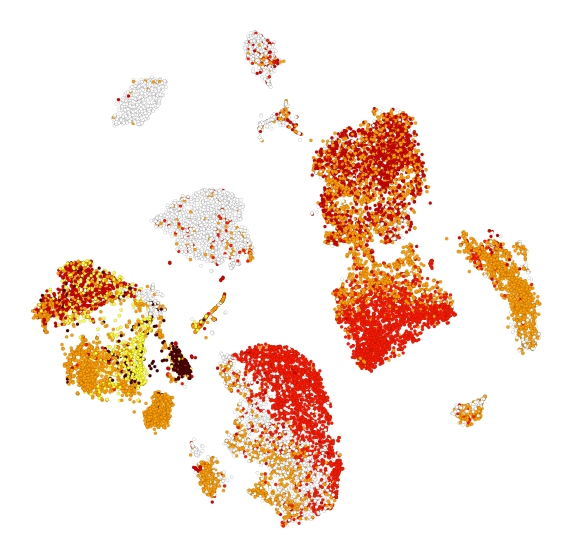

In [101]:
fig,ax = plt.subplots(figsize=(10,10))

order_ = np.random.choice(sc.tsne_log.shape[0],size=sc.tsne_log.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
         c=np.array(colors)[order_],s=10,linewidths=.1,edgecolor='k')
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure5/EpiImmuneInt_tSNE_Modules_step.png",bbox_inches='tight')

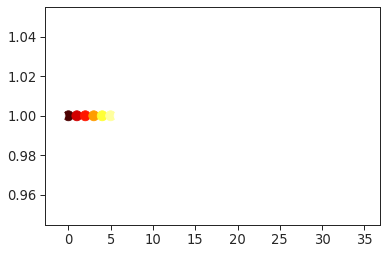

In [102]:
pal_list = np.array([palette[i] for i in palette.keys()])
plt.scatter(list(palette.keys()),[1]* len(palette.keys()),c=pal_list,s=100)

In [75]:
list(palette.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]

In [76]:
pal_list

array([(0.0416, 0.0, 0.0, 1.0), (0.2989711013608711, 0.0, 0.0, 1.0),
       (0.5666370467761772, 0.0, 0.0, 1.0),
       (0.8240081481370484, 0.0, 0.0, 1.0),
       (1.0, 0.09166747604035141, 0.0, 1.0),
       (1.0, 0.359314099938117, 0.0, 1.0),
       (1.0, 0.6166666229167378, 0.0, 1.0),
       (1.0, 0.8843132468145034, 0.0, 1.0),
       (1.0, 1.0, 0.21249921249921258, 1.0),
       (1.0, 1.0, 0.6139702022054964, 1.0), '#FFFFFF'], dtype=object)

## Quantifications

In [78]:
IL4expressing = np.where(sc.data_full['IL4'].values>0)[0]
ST2expressing = np.where(sc.data_full['IL1RL1'].values>0)[0]
allcells = set(np.arange(sc.data_full.shape[0]))

In [79]:
both = list(np.intersect1d(IL4expressing,ST2expressing))
neither = list(allcells - set(IL4expressing) - set(ST2expressing))
IL4only = list(set(IL4expressing) - set(ST2expressing))
ST2only = list(set(ST2expressing) - set(IL4expressing))

In [80]:
len(both+neither+IL4only+ST2only) == sc.data.shape[0]

True

In [81]:
table_ = np.array([[len(both),len(ST2only)],[len(IL4only),len(neither)]])
scipy.stats.fisher_exact(table_,alternative='greater')

(21.474798106377055, 9.877260001845418e-35)

In [82]:
table_

array([[   40,   399],
       [   90, 19279]])

In [83]:
IL33expressing_epi = np.where(sc.data_full['IL33'].values[epi_cells]>0)[0]
gastric_epi = np.where(assignments_epi[epi_cells]==5)[0]

In [86]:
len(np.intersect1d(IL33expressing_epi,gastric_epi))/len(gastric_epi)

0.03915838690824079

In [87]:
IL4RAexpressing = np.where(sc.data_full['IL4RA'].values>0)[0]

In [88]:
sc.genes_full = list(sc.data_full)
sc.data_full = csr_matrix(sc.data_full.values)

In [89]:
save_sc(sc,working_dir+"saved_analyses/ImmuneEpi_Coembedding-v2.pickle")